# **INGEST**

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers

In [ ]:
drive.mount('/content/gdrive')
train=pd.read_csv('gdrive/My Drive/Data/train-mnist.csv')
test=pd.read_csv('gdrive/My Drive/Data/test_mnist.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **EDA**

In [ ]:
y_train=train['label'].values
x_train=(train.iloc[:,1:].values).astype('float64')
x_test=(test.iloc[:,:].values).astype('float64')

In [ ]:
x_train, x_valid, y_train, y_valid=train_test_split(x_train, y_train, stratify=y_train,random_state=456,test_size=0.2  )

In [ ]:
x_train=(x_train.reshape(x_train.shape[0],28,28))/255
x_valid=(x_valid.reshape(x_valid.shape[0],28,28))/255
x_test=(x_test.reshape(x_test.shape[0],28,28))/255
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(33600, 28, 28)
(8400, 28, 28)
(28000, 28, 28)


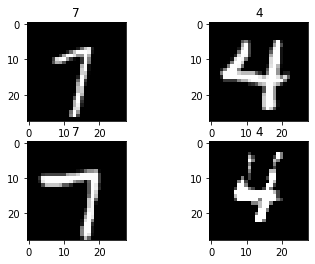

In [ ]:
for i in range(0, 4):
    plt.subplot(220 + (i+1))
    plt.imshow(x_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

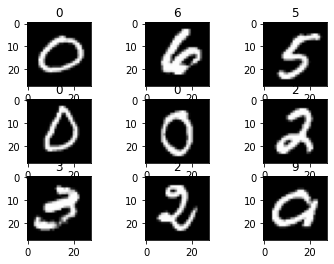

In [ ]:
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_valid[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(y_valid[i])

# **MODEL & EVALUATE**

Stacked Autoencoder

In [ ]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(500, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(500, activation="selu", input_shape=[100]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100)               442600    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            443284    
Total params: 885,884
Trainable params: 885,884
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = stacked_ae.fit(x_train, x_train, epochs=10, validation_data=(x_valid, x_valid))

Epoch 1/10
1050/1050 [==============================] - 12s 11ms/step - loss: 0.2115 - val_loss: 0.1135
Epoch 2/10
1050/1050 [==============================] - 10s 10ms/step - loss: 0.1065 - val_loss: 0.0951
Epoch 3/10
1050/1050 [==============================] - 11s 10ms/step - loss: 0.0924 - val_loss: 0.0881
Epoch 4/10
1050/1050 [==============================] - 10s 10ms/step - loss: 0.0863 - val_loss: 0.0843
Epoch 5/10
1050/1050 [==============================] - 10s 10ms/step - loss: 0.0831 - val_loss: 0.0817
Epoch 6/10
1050/1050 [==============================] - 11s 10ms/step - loss: 0.0808 - val_loss: 0.0800
Epoch 7/10
1050/1050 [==============================] - 10s 10ms/step - loss: 0.0791 - val_loss: 0.0786
Epoch 8/10
1050/1050 [==============================] - 10s 9ms/step - loss: 0.0779 - val_loss: 0.0779
Epoch 9/10
1050/1050 [==============================] - 10s 10ms/step - loss: 0.0771 - val_loss: 0.0766
Epoch 10/10
1050/1050 [==============================] - 10s 10ms

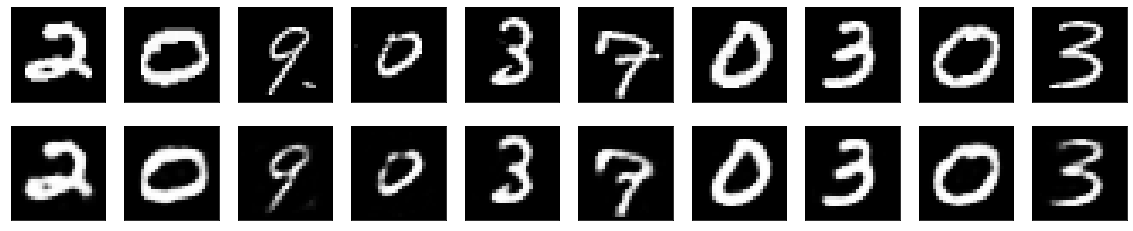

In [ ]:
reconstruct_image=stacked_ae.predict(x_test)
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruct_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Convolutional Autoencoder

In [ ]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="selu",input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
conv_ae.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_13 (Sequential)   (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = conv_ae.fit(x_train, x_train, epochs=10, validation_data=(x_valid, x_valid))

Epoch 1/10
1050/1050 [==============================] - 40s 38ms/step - loss: 0.1668 - val_loss: 0.0875
Epoch 2/10
1050/1050 [==============================] - 41s 39ms/step - loss: 0.0868 - val_loss: 0.0801
Epoch 3/10
1050/1050 [==============================] - 41s 39ms/step - loss: 0.0803 - val_loss: 0.0772
Epoch 4/10
1050/1050 [==============================] - 41s 39ms/step - loss: 0.0773 - val_loss: 0.0759
Epoch 5/10
1050/1050 [==============================] - 42s 40ms/step - loss: 0.0757 - val_loss: 0.0761
Epoch 6/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.0746 - val_loss: 0.0736
Epoch 7/10
1050/1050 [==============================] - 40s 38ms/step - loss: 0.0737 - val_loss: 0.0735
Epoch 8/10
1050/1050 [==============================] - 40s 38ms/step - loss: 0.0727 - val_loss: 0.0726
Epoch 9/10
1050/1050 [==============================] - 39s 37ms/step - loss: 0.0721 - val_loss: 0.0726
Epoch 10/10
1050/1050 [==============================] - 39s 38m

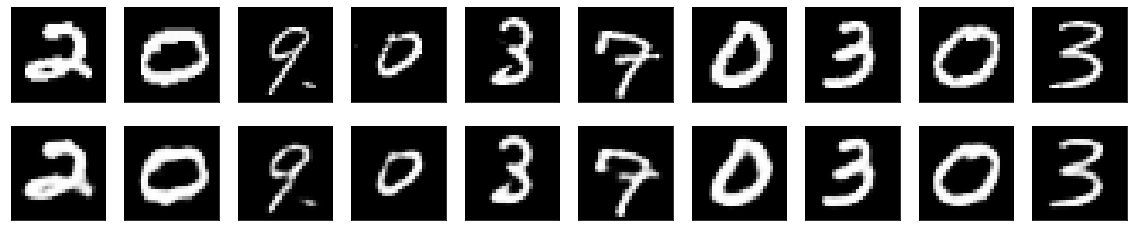

In [ ]:
reconstruct_image=conv_ae.predict(x_test)
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruct_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Recurrent Autoencoder

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
recurrent_ae.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 30)                67320     
_________________________________________________________________
sequential_16 (Sequential)   (None, 28, 28)            55228     
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = recurrent_ae.fit(x_train, x_train, epochs=10, validation_data=(x_valid, x_valid))

Epoch 1/10
1050/1050 [==============================] - 58s 51ms/step - loss: 0.3189 - val_loss: 0.2770
Epoch 2/10
1050/1050 [==============================] - 52s 50ms/step - loss: 0.2671 - val_loss: 0.2461
Epoch 3/10
1050/1050 [==============================] - 54s 51ms/step - loss: 0.2414 - val_loss: 0.2249
Epoch 4/10
1050/1050 [==============================] - 54s 51ms/step - loss: 0.2138 - val_loss: 0.1948
Epoch 5/10
1050/1050 [==============================] - 54s 51ms/step - loss: 0.1918 - val_loss: 0.1765
Epoch 6/10
1050/1050 [==============================] - 53s 50ms/step - loss: 0.1768 - val_loss: 0.1595
Epoch 7/10
1050/1050 [==============================] - 54s 51ms/step - loss: 0.1625 - val_loss: 0.1470
Epoch 8/10
1050/1050 [==============================] - 55s 52ms/step - loss: 0.1472 - val_loss: 0.1401
Epoch 9/10
1050/1050 [==============================] - 54s 51ms/step - loss: 0.1389 - val_loss: 0.1340
Epoch 10/10
1050/1050 [==============================] - 55s 52m

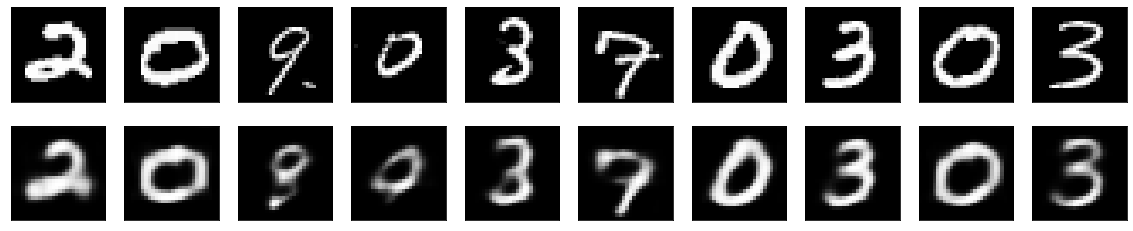

In [ ]:
reconstruct_image=recurrent_ae.predict(x_test)
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruct_image[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **CONCLUSION**

There are 3 autoencoder models built, including stacked autoencoder, convolutional autoencoder and recurrent autoencoder. Stacked autoencoder runs the fastest, while convolutional autoencoder has the best reconstructive images. However, it takes the longest time for recurrent autoencoder to train, and it also has the worest reconstructive image outputs. 